# 1. Boundary issues

## Introduction

The Gaussian distribution ranges from $-\infty$ to $+\infty$. Thus, the Gaussian KDE also has an unlimited support. In practice we don't use a grid ranging from $-\infty$ to $+\infty$ because the great majority of the support will have almost a null probability. We just extend the observed range by one standard deviation and that usually is enough. 

A naive approach consists of truncating the support of $\hat{f}(x)$. For example, one could truncate it to $[0, \infty]$ and set $\hat{f}(x) = 0$ for all $x \lt 0$. The problem with this approach is that the density does not integrate to the unity anymore. A re-scaling of the KDE is a possible solution but it is not obvious how it should be done.

Let's simulate 500 random values from a $\chi_3^2$ distribution and estimate the density with and without range extension.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]

import sys
sys.path.append('../src/')
from my_functions import *

POMENGRATE = "#c0392b"
ALIZARIN = "#e74c3c"
BELIZE_HOLE = "#2980b9"

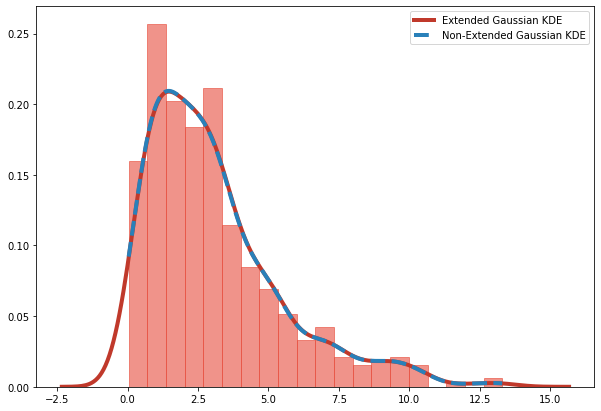

In [3]:
np.random.seed(1234)

rvs = np.random.chisquare(3, 500)

x_ext, y_ext = convolution_kde(rvs, extend=True)
x_next, y_next = convolution_kde(rvs, extend=False)

plt.plot(x_ext, y_ext, linewidth=4, color=POMENGRATE, label="Extended Gaussian KDE")
plt.plot(x_next, y_next, linewidth=4, linestyle="--", color=BELIZE_HOLE, label="Non-Extended Gaussian KDE")
plt.hist(rvs, density=True, bins=20, alpha=0.6, Color=ALIZARIN)

plt.legend()
plt.show()

It is clear the area below the blue curve is smaller than the area below the red curve. Obtaining an estimation via a Gaussian KDE and restricting the domain to the observed range is not a good idea.

In [4]:
from scipy.integrate import simps

red_area = simps(y_ext, x_ext)
blue_area = simps(y_next, x_next)

print(f"The area under the red curve is {red_area:.3f}")
print(f"The area under the blue curve is {blue_area:.3f}")

The area under the red curve is 1.004
The area under the blue curve is 0.959


A straightforward solution is to normalize the estimated density so it integrates up to 1. We can just mutiply each density point by the inverse of the area under the curve.

In [5]:
y_next = y_next * (1 / blue_area)

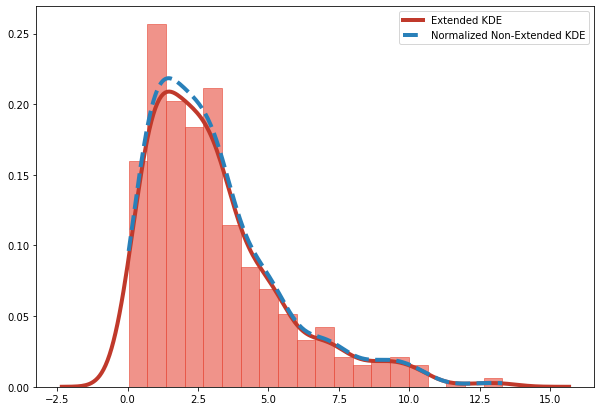

In [6]:
plt.plot(x_ext, y_ext, linewidth=4, color=POMENGRATE, label="Extended KDE")
plt.plot(x_next, y_next, linewidth=4, linestyle="--", color=BELIZE_HOLE, label="Normalized Non-Extended KDE")
plt.hist(rvs, density=True, bins=20, alpha=0.6, Color=ALIZARIN)

plt.legend()
plt.show()

In [7]:
print(f"The area under the blue curve is {simps(y_next, x_next):.3f}")

The area under the blue curve is 1.000


# 2. Reflection method

There's a procedure based on **reflection** of some KDE parts. Let the admisible domain be $X \in [X_*, \infty]$. The kernel $\kappa$ plotted in the thin solid line refers to a data point $X_i$. Note that a part of this kernel lies outside the admissible domain and, as a consequence, the left-cut fragment of the kernel $\kappa$ does not integrate to one (the area $P1 + P2 \lt 1$).  
Therefore, the idea is to add the missing probability mass represented by the area $P2$ to the kernel $\kappa$. The reflected kernel $\kappa$, plotted in the dashed line in the leftmost part of the figure, is centered at the point $2X_* - X_i$. Now, it is easy to notice that $P2 = P3$. Finally, the new kernel represented by the areas $P1 + P2 + P3$ integrates to one.

From the ponit of view of analysis, it can be said that he descried procedure sums two kernels jointly with the indicator function. 

<div>
<img src="imgs/fig_3_16.png",width=600, height="600"/>
</div>


Let's define the the left and right side boundary corrections, respectively: 

$$
\hat{f}(x, h) = \frac{1}{Nh}\sum_{i=1}^{N}{\left[\kappa\left(\frac{x - X_i}{h}\right) + \kappa\left(\frac{x - (2X_* - X_i)}{h}\right) \right]\mathbb{1}_{\{x \in [X_*, \infty)\}}}
$$

$$
\hat{f}(x, h) = \frac{1}{Nh}\sum_{i=1}^{N}{\left[\kappa\left(\frac{x - X_i}{h}\right) + \kappa\left(\frac{x - (2X_* - X_i)}{h}\right) \right]\mathbb{1}_{\{x \in (-\infty, X_*]\}}}
$$

Let's rewrite `gaussian_kde()` and `convolution_kde()` to incorporate the boundary correction feature.

As mentioned in the previous notebook, `theta_kde()` already handles boundary conditions in a proper way.

In [8]:
def gaussian_kde(x, h=None, bc=False):
    
    """
    Naive, inefficient, but straightforward Gaussian KDE
    
    Parameters
    ----------
    x : array-like
        1 dimensional array of the variable for which a 
        density estimate is desired.
    h : float, optional
        Bandwidth (standard deviation of each Gaussian component)
        Defaults to None, which uses gaussian rule of thumb.
    bc : boolean, optional
         Indicates if boundary correction should be performed or not
    
    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    
    """
    
    x_std = np.std(x)
    x_len = len(x)
    
    x_min = np.min(x)
    x_max = np.max(x)

    grid_len = 500
    
    pdf_mat = np.zeros((x_len, grid_len))
    
    if h is None:
        s = min(x_std, stats.iqr(x) / 1.34)
        h = 1.058 * s * x_len ** (-0.2)    
    
    if bc:
        x_pad_len = 3 * x_len
        x_pad_min = 2 * x_min - x_max
        x_pad_max = 2 * x_max - x_min
        
        grid_pad_len = 3 * grid_len
        grid_pad = np.linspace(x_pad_min, x_pad_max, num=grid_pad_len)

        pdf_mat = np.zeros((x_len, grid_pad_len))
        
        for i in range(0, x_len):
            mu = x[i]
            mu_lpad = (2 * x_min) - x[i]
            mu_rpad = (2 * x_max) - x[i]
            
            x_comp = np.exp(-0.5 * ((grid_pad - mu) / h) ** 2) / (np.sqrt(2 * np.pi) * h)
            x_lpad_comp = np.exp(-0.5 * ((grid_pad - mu_lpad) / h) ** 2) / (np.sqrt(2 * np.pi) * h)
            x_rpad_comp = np.exp(-0.5 * ((grid_pad - mu_rpad) / h) ** 2) / (np.sqrt(2 * np.pi) * h)
            
            comp = x_comp + x_lpad_comp + x_rpad_comp
            comp[(grid_pad < x_min) | (grid_pad > x_max)] = 0
            
            pdf_mat[i, :] = comp
            
        grid = grid_pad[grid_len:(2 * grid_len)]
        pdf = np.mean(pdf_mat, axis=0)[grid_len:(2 * grid_len)]
        
    else:
        grid_min = np.min(x) - 1 * x_std
        grid_max = np.max(x) + 1 * x_std
        grid = np.linspace(grid_min, grid_max, num=grid_len)
    
        pdf_mat = np.zeros((x_len, grid_len))

        for i in range(0, x_len):
            mu = x[i]
            pdf_mat[i, :] = np.exp(-0.5 * ((grid - mu) / h) ** 2) / (np.sqrt(2 * np.pi) * h)
            
        grid = grid
        pdf = np.mean(pdf_mat, axis=0)
        
    return grid, pdf   

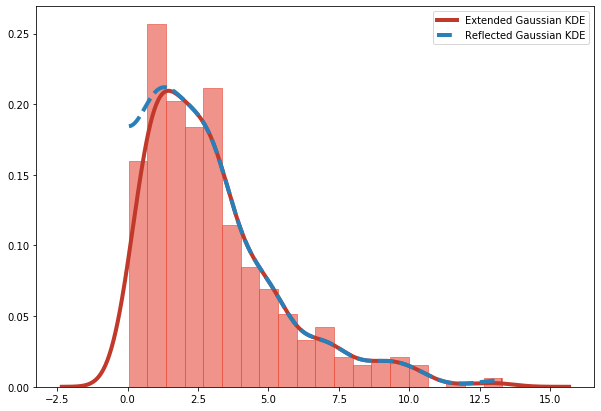

In [9]:
np.random.seed(1234)

rvs = np.random.chisquare(3, 500)

x_ext, y_ext = gaussian_kde(rvs, bc=False)
x_bc, y_bc = gaussian_kde(rvs, bc=True)

plt.plot(x_ext, y_ext, linewidth=4, color=POMENGRATE, label="Extended Gaussian KDE")
plt.plot(x_bc, y_bc, linewidth=4, linestyle="--", color=BELIZE_HOLE, label="Reflected Gaussian KDE")
plt.hist(rvs, density=True, bins=20, alpha=0.6, Color=ALIZARIN)

plt.legend()
plt.show()

In [10]:
print(f"The area under the blue curve is {simps(y_bc, x_bc):.3f}")

The area under the blue curve is 0.998


Now we also implement it for the `convolution_kde()`.

In [11]:
def convolution_kde(x, h=None, grid_len=None, extend=True, bc=False):
    
    """
    Gaussian KDE via convolution of empirical distribution with Gaussian signal
    
    Parameters
    ----------
    x : array-like
        1 dimensional array of the observed data for which a 
        density estimate is desired.
    h : float, optional
        Bandwidth (standard deviation of each Gaussian component)
        Defaults to None, which uses gaussian rule of thumb.
    grid_len : int, optional
        Number of points where the kernel is evaluated. 
        Defaults to None, which means 256 grid points.
    extend: boolean, optional
        Whether to extend the domain of the observed data
        or not. Defaults to True.
    bc : boolean, optional
        Indicates if boundary correction should be performed or not.
        Overrides `extend`.
    
    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    
    """
    
    # Calculate preliminary values
    x_len = len(x)
    x_max = np.max(x)
    x_min = np.min(x)
    x_range = x_max - x_min
    x_std = np.std(x)
    
    # Set up number of bins
    if grid_len is None:
        grid_len = 256
    elif grid_len > 512:
        grid_len = 512
    else:
        grid_len = 2 ** np.ceil(np.log2(grid_len))
    
    # Set up grid length
    if extend and not bc:
        grid_min = x_min - 1 * x_std
        grid_max = x_max + 1 * x_std
    else:
        grid_min = x_min
        grid_max = x_max
       
    # Calculate relative frequencies per bin
    f, edges = np.histogram(x, bins=grid_len, range=(grid_min, grid_max), density=True)  
    
    # Bin width
    bin_width = (grid_max - grid_min) / (grid_len - 1)
    
    if h is None:
        x_std = x_std
        s = min(x_std, stats.iqr(x) / 1.34)
        h = 1.058 * s * x_len ** (-0.2) 
        
    # Bandwidth must consider the bin width
    h /= bin_width
    
    kernel = gaussian(120, h)
    
    if bc:
        npad = int(grid_len / 4)
        f = np.concatenate([f[npad:0:-1], f, f[grid_len : grid_len - npad : -1]])
        pdf = convolve(f, kernel, mode="same", method="direct")[npad : npad + grid_len]
        pdf = pdf / sum(kernel)
    else:
        pdf = convolve(f, kernel, mode="same", method="fft") / sum(kernel)
    
    grid = np.linspace(grid_min, grid_max, num=grid_len)
    # alternative
    # grid = 0.5 * (edges[1:] + edges[:-1]) 
    
    return grid, pdf

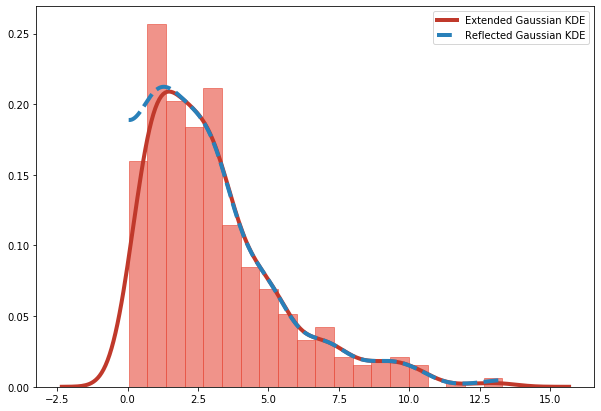

In [12]:
np.random.seed(1234)

rvs = np.random.chisquare(3, 500)

x_ext, y_ext = convolution_kde(rvs, bc=False)
x_bc, y_bc = convolution_kde(rvs, bc=True)

plt.plot(x_ext, y_ext, linewidth=4, color=POMENGRATE, label="Extended Gaussian KDE")
plt.plot(x_bc, y_bc, linewidth=4, linestyle="--", color=BELIZE_HOLE, label="Reflected Gaussian KDE")
plt.hist(rvs, density=True, bins=20, alpha=0.6, Color=ALIZARIN)

plt.legend()
plt.show()

And finally, same results can be obtained with `theta_kde()`.

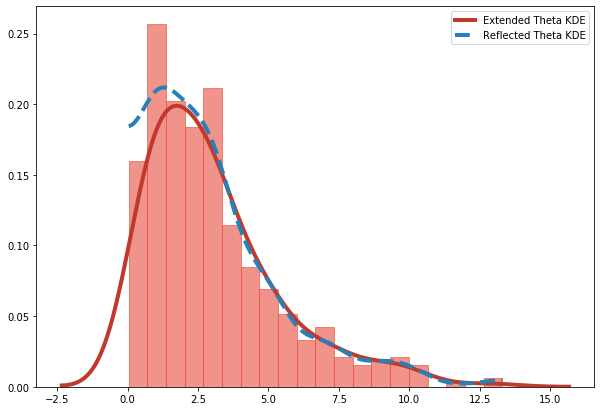

In [13]:
np.random.seed(1234)

rvs = np.random.chisquare(3, 500)

x_ext, y_ext = theta_kde(rvs, extend=True)
x_bc, y_bc = theta_kde(rvs, extend=False)

plt.plot(x_ext, y_ext, linewidth=4, color=POMENGRATE, label="Extended Theta KDE")
plt.plot(x_bc, y_bc, linewidth=4, linestyle="--", color=BELIZE_HOLE, label="Reflected Theta KDE")
plt.hist(rvs, density=True, bins=20, alpha=0.6, Color=ALIZARIN)

plt.legend()
plt.show()

# 3. Time comparisons

In [14]:
import datetime
from timeit import default_timer as timer

def iterator(f, loops=50, **kwargs):
    start = timer()
    for i in range(0, loops):
        f(**kwargs)
    end = timer()
    return ((end - start) / loops)

In [16]:
np.random.seed(1234)
sizes = [1000, 2000, 5000, 10000, 20000]

time_naive = []
time_convolution = []
time_theta = []

for i in range(0, len(sizes)):
    
    size = sizes[i]
    data = stats.norm.rvs(size=int(size))

    time_naive.append(iterator(gaussian_kde, x=data, bc=True))
    time_convolution.append(iterator(convolution_kde, x=data, bc=True))
    time_theta.append(iterator(theta_kde, x=data, extend=False))
    
    print("Size " + str(size) + " done.")

Size 1000 done.
Size 2000 done.
Size 5000 done.
Size 10000 done.
Size 20000 done.


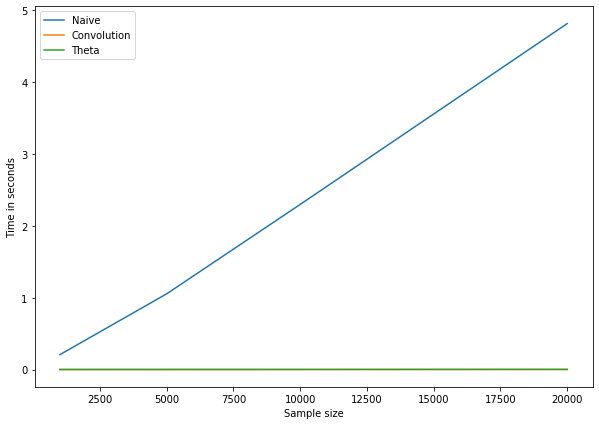

In [17]:
plt.plot(sizes, time_naive, label="Naive")
plt.plot(sizes, time_convolution, label="Convolution")
plt.plot(sizes, time_theta, label="Theta")
plt.xlabel("Sample size")
plt.ylabel("Time in seconds")

plt.legend()
plt.show()

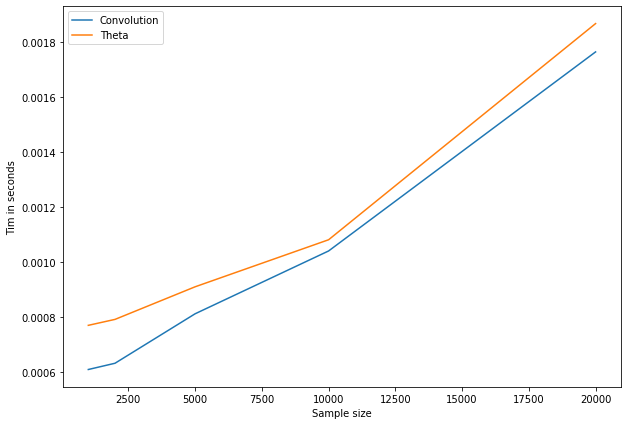

In [18]:
plt.plot(sizes, time_convolution, label="Convolution")
plt.plot(sizes, time_theta, label="Theta")
plt.xlabel("Sample size")
plt.ylabel("Tim in seconds")

plt.legend()
plt.show()

In [20]:
np.array(time_convolution) / np.array(time_theta)

array([0.79088571, 0.79803657, 0.89194628, 0.96225287, 0.94478723])